Data Processing

In [25]:
!pip install tensorflow matplotlib numpy scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Example: Splitting the dataset into train, test, and validation
dataset_path = 'dataset_resized'
output_path = 'output_dataset'

# Create directories for train, test, and validation sets
for split_type in ['train', 'test', 'validation']:
    os.makedirs(os.path.join(output_path, split_type), exist_ok=True)

classes = os.listdir(dataset_path)
print(classes)

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_path, img) for img in os.listdir(class_path)]

    # Split into train, test, and validation
    train_val_images, test_images = train_test_split(images, test_size=0.1, random_state=42)
    train_images, val_images = train_test_split(train_val_images, test_size=0.1, random_state=42)

    # Copy images to respective directories
    for img_list, split_dir in zip([train_images, test_images, val_images], ['train', 'test', 'validation']):
        os.makedirs(os.path.join(output_path, split_dir, class_name), exist_ok=True)
        for img_path in img_list:
            shutil.copy(img_path, os.path.join(output_path, split_dir, class_name, os.path.basename(img_path)))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Prepare dataset

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define dataset and image settings
dataset_path = 'dataset_resized'
img_width, img_height = 224, 224
num_classes = 6
batch_size = 32

# Create ImageDataGenerators for data loading and augmentation
# The validation_split is used to create a validation set from the training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=25,
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2  # 20% of data for validation
)

# Load and prepare the training and validation data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

print(train_generator.class_indices)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


Build the CNN model

In [28]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.initializers import HeNormal
# Define the CNN model architecture
he_init = HeNormal()

model = models.Sequential([
    # Conv1
    layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu',
                  kernel_initializer=he_init, input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # Conv2
    layers.Conv2D(256, (5, 5), padding='same', activation='relu', kernel_initializer=he_init),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # Conv3
    layers.Conv2D(384, (3, 3), padding='same', activation='relu', kernel_initializer=he_init),

    # Conv4
    layers.Conv2D(384, (3, 3), padding='same', activation='relu', kernel_initializer=he_init),

    # Conv5
    layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer=he_init),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Flatten(),

    # FC6
    layers.Dense(4096, activation='relu', kernel_initializer=he_init),
    layers.Dropout(0.5),

    # FC7
    layers.Dense(4096, activation='relu', kernel_initializer=he_init),
    layers.Dropout(0.5),

    # Output
    layers.Dense(num_classes, activation='softmax')
])


# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the model
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,771,590 (178.42 MB)

 Trainable params: 46,771,590 (178.42 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [29]:
epochs = 30
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = train_generator.samples // train_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

# Specify the filename for your HDF5 file
h5_filepath = 'trashnet_model.h5'

# Save the model to the HDF5 format
model.save(h5_filepath)

print(f"Model saved to {h5_filepath}")

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 311ms/step - accuracy: 0.2219 - loss: 3.2520 - val_accuracy: 0.2346 - val_loss: 1.8068
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2500 - loss: 1.8002 - val_accuracy: 0.2346 - val_loss: 1.7597
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.2259 - loss: 1.7301 - val_accuracy: 0.2346 - val_loss: 1.7229
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.1562 - loss: 1.8111 - val_accuracy: 0.2346 - val_loss: 1.7229
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.2329 - loss: 1.7268 - val_accuracy: 0.2346 - val_loss: 1.7259
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.1562 - loss: 1.8967 - val_accuracy: 0.2346 - val_loss: 1.7255
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 335ms/step - accuracy: 0.2304 - loss: 1.7312 - val_accuracy: 0.2346 - val_loss: 1.7261
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.2500 - loss: 1.7006 - val_accuracy: 0.

Model saved to trashnet_model.h5


Evaluate and visualize

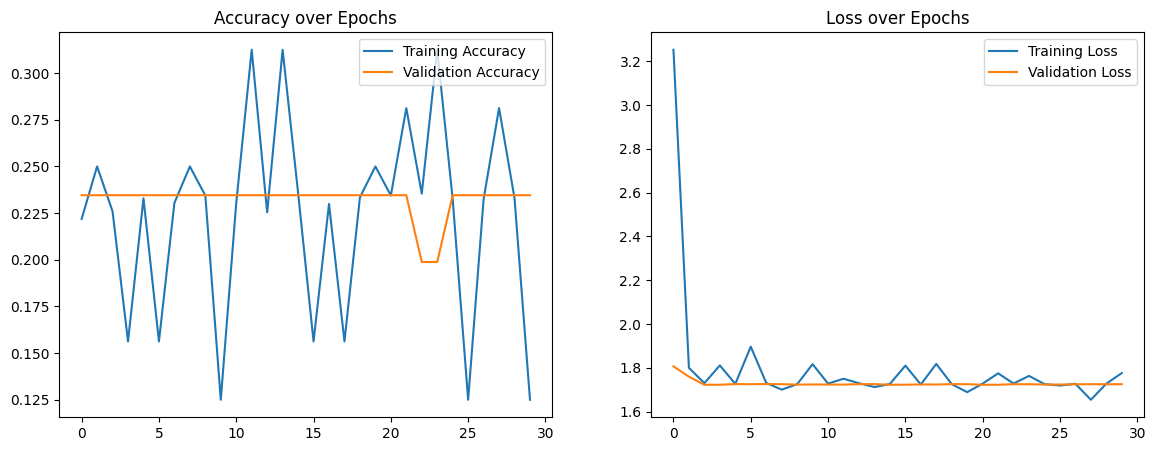

In [30]:
# Plot training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()